In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Aug 26 20:24:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P8    14W / 230W |  21594MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 80
n_outputs = 61
n_frames = 400

In [4]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
model.eval()
print('done')

done


In [11]:
!ls -lt /data/scpark/save/lips/train08.14-3/

total 643560
-rw-rw-r-- 1 scpark scpark 658999517  8월 21 14:39 save_140000


In [12]:
path = '/data/scpark/save/lips/train08.14-3/save_140000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [7]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 zeroone scpark  1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark  vivernd 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark  vivernd 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 zeroone scpark  1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 zeroone scpark  1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 zeroone scpark   983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 zeroone scpark   971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 zeroone scpark   954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 zeroone scpark   944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 zeroone scpark   944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 zeroone scpark   928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 zeroone scpark   920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 zeroone scpark   920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 zeroone scpark   917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 zeroone scpark   917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 zeroone scpark   913841  5월 11 19:48 1098.sp

-rwxrwxrwx 1 scpark  vivernd  406276 11월 13  2019 1723.wav
-rwxrwxrwx 1 scpark  vivernd  406256 11월 13  2019 1032.wav
-rwxrwxrwx 1 scpark  vivernd  406132 11월 13  2019 828.wav
-rwxrwxrwx 1 scpark  vivernd  405960 11월 13  2019 1099.wav
-rwxrwxrwx 1 scpark  vivernd  405606 11월 13  2019 340.wav
-rwxrwxrwx 1 scpark  vivernd  405500 11월 13  2019 1228.wav
-rwxrwxrwx 1 scpark  vivernd  405372 11월 13  2019 329.wav
-rw-r--r-- 1 zeroone scpark   404971  5월 11 19:49 87.spec.pt
-rwxrwxrwx 1 scpark  vivernd  404884 11월 13  2019 1986.wav
-rwxrwxrwx 1 scpark  vivernd  404282 11월 13  2019 947.wav
-rwxrwxrwx 1 scpark  vivernd  404262 11월 13  2019 405.wav
-rwxrwxrwx 1 scpark  vivernd  404216 11월 13  2019 358.wav
-rwxrwxrwx 1 scpark  vivernd  403778 11월 13  2019 1875.wav
-rwxrwxrwx 1 scpark  vivernd  403378 11월 13  2019 1405.wav
-rwxrwxrwx 1 scpark  vivernd  403008 11월 13  2019 1160.wav
-rwxrwxrwx 1 scpark  vivernd  402820 11월 13  2019 1610.wav
-rwxrwxrwx 1 scpark  vivernd  402476 11월 13  2019 1209.wav
-

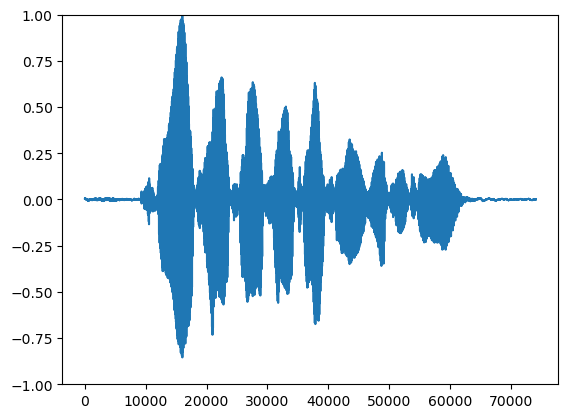

In [13]:
import matplotlib.pyplot as plt
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
#wav_file = '/Storage/speech/tts/kaist-audio-book/wav/여1_동화1/1181.wav'
wav_file = 'samples/good.wav'
wav, _ = librosa.load(wav_file, sr=24000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

In [14]:
from functools import partial
from data.audio import mel_spectrogram
get_mel = partial(mel_spectrogram, n_fft=2048, num_mels=80, sampling_rate=24000, hop_size=800, win_size=2048, fmin=0, fmax=None, center=False, return_spec=False)
    
def get_blendshape(wav, sid):
    mel = get_mel(torch.Tensor(wav).unsqueeze(0)).to(device)
    sid = torch.Tensor([sid]).long().to(device)
    with torch.no_grad():
        y = model.inference(mel, sid=sid, temperature=0.1)
    y = y[0].data.cpu().numpy()
    return mel[0].data.cpu().numpy(), y
    
ys = []
for sid in range(1, 8):
    mel, y = get_blendshape(wav, sid)
    ys.append(y)
    
ys = np.stack(ys)
print(ys.shape)

np.save('samples/infer08.14-3.npy', ys)
print('done')

(7, 61, 92)
done


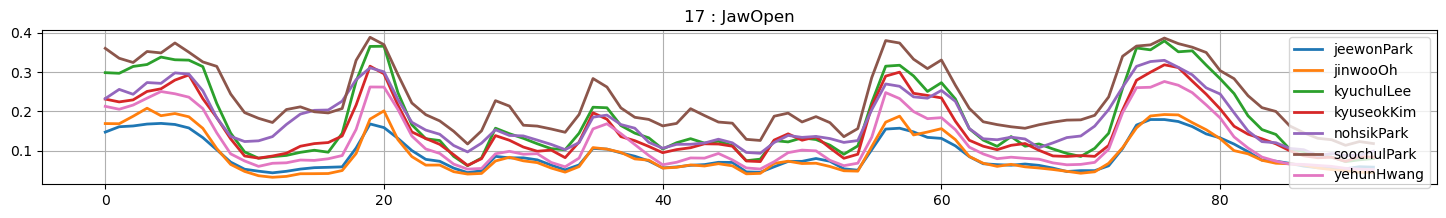

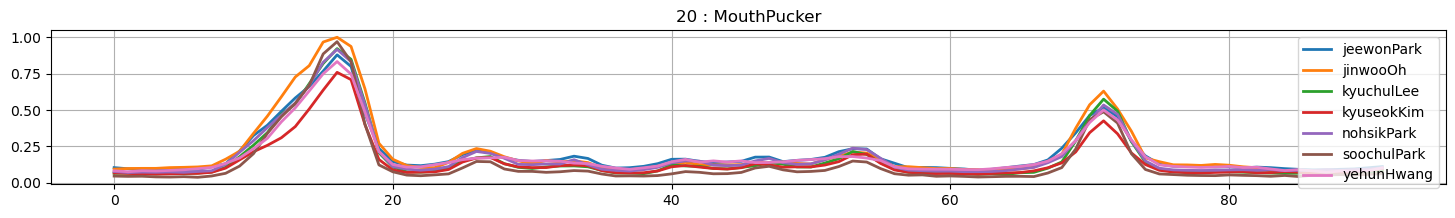

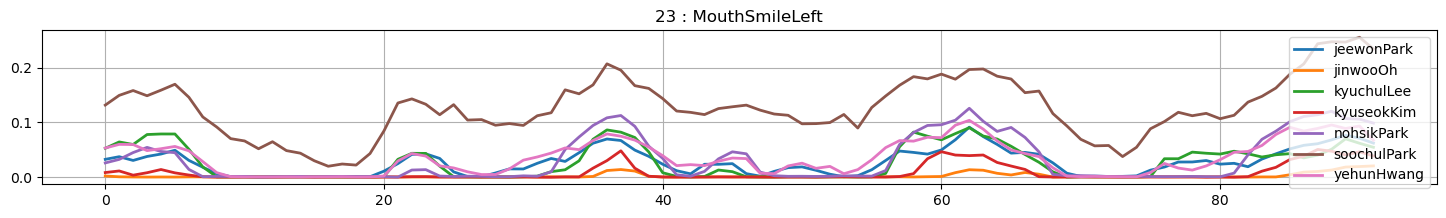

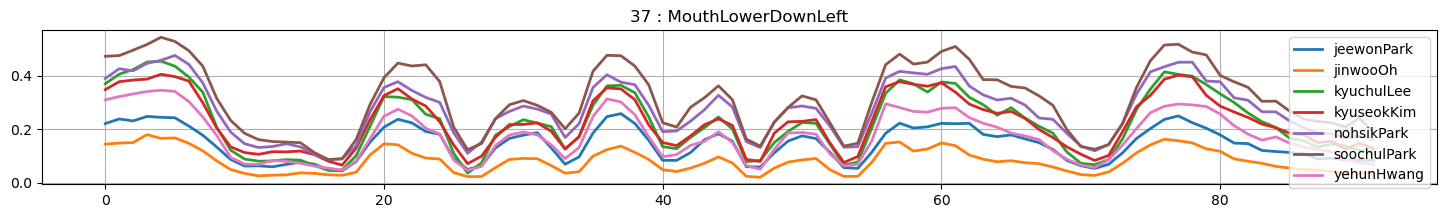

In [15]:
names = ['jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
targets = [(17, 'JawOpen'), (20, 'MouthPucker'), (23, 'MouthSmileLeft'), (37, 'MouthLowerDownLeft')]

for target in targets:
    plt.figure(figsize=[18, 2])
    plt.title(str(target[0]) + ' : ' + target[1])
    for i in range(len(ys)):
        plt.plot(ys[i][target[0]], label=names[i], linewidth=2)
    plt.grid()
    plt.legend()
    plt.show()